# Validation of Trained All IBD Fatigue ML Model on Australian Data

Validation data provided by Dr Nikita Prakash and Dr Ray Boyapati.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras
import numpy as np
import pickle
import shap
import statsmodels.api as sm
from pathlib import Path

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from src.data.preprocessing import map_season_australia, fill_missing_values_with_saved_medians
from src.config.constants import NUMERICAL_FEATURES
from src.config.paths import VALIDATION_AUSTRALIA_DIR, ensure_output_dirs, DNN_DIR, BENCHMARKING_DIR
from src.visualization.plotting import plot_missing_data_heatmap
from src.data.conversions import capitalize_first_letter

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

In [2]:
ensure_output_dirs()
output_path = VALIDATION_AUSTRALIA_DIR
target_path = DNN_DIR / "exports" / "X_test.csv"

In [3]:
df = pd.read_excel(
    "data/fatigue_ml_data_validation_australia.xlsx", sheet_name="Fatigue_validation_cleaned"
)

In [4]:
target_df = pd.read_csv(target_path)

## Data Cleaning

In [5]:
cols_to_rename = {
    "height_cm": "height",
    "weight_kg": "weight",
    "has_symptoms_of_active_ibd": "has_active_symptoms",
    "sampling_aminosalicylates (any)": "sampling_asa",
    "sampling_antibiotics": "sampling_abx",
    "study_group": "study_group_name",
    "smoking_status": "is_smoker",
}

df.rename(columns=cols_to_rename, inplace=True)

In [6]:
medians_path = DNN_DIR / "exports" / "medians.json"
df = fill_missing_values_with_saved_medians(df, medians_path=medians_path)

## Transform Excel Data to Match Input DataFrame

In [7]:
df["fatigue_outcome"] = df[
    "On how many days over the last 14 days have you felt fatigued? (0-14)"
].apply(lambda x: 1 if x >= 10 else 0)

In [8]:
# Strip whitespace from values in the following columns
cols_to_strip_whitespace = [
    "sex",
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_severity",
    "montreal_uc_extent"
]

for col in cols_to_strip_whitespace:
    df[col] = df[col].astype(str).str.strip()

In [9]:
cols_to_fix_nan = [
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_severity",
    "montreal_uc_extent"
]

for col in cols_to_fix_nan:
    df[col] = df[col].replace("nan", np.nan)

In [10]:
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})

In [11]:
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

In [12]:
# calculate age at diagnosis based on age this year 2025, minus the year of date_of_diagnosis
df["age_at_diagnosis"] = df["age"] - (2025 - df["date_of_diagnosis"].dt.year)

## Feature Engineering

In [13]:
df["date_recorded"] = pd.to_datetime(df["date_recorded"])
df["disease_duration_weeks"] = (
    df["date_recorded"] - df["date_of_diagnosis"]
).dt.days / 7
df["season"] = df["date_recorded"].apply(map_season_australia)
df["diagnosis_year"] = df["date_of_diagnosis"].dt.year

In [14]:
df["study_group_name"] = df["study_group_name"].apply(lambda x: x.upper())

In [15]:
# Change Yes and No to 1 and 0 for the following columns
cols_to_map = [
    "montreal_upper_gi",
    "montreal_perianal",
    "sampling_steroids",
    "sampling_abx",
    "sampling_asa",
    "sampling_aza",
    "sampling_mp",
    "sampling_ifx",
    "sampling_ada",
    "sampling_vedo",
    "sampling_uste",
    "sampling_tofa",
    "sampling_mtx",
    "sampling_ciclosporin",
    "sampling_filgo",
    "sampling_upa",
    "sampling_risa",
    "has_active_symptoms",
]

for col in cols_to_map:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [16]:
# Before replacement - check current values
print("Before replacement:")
print(df["montreal_cd_behaviour"].value_counts())

# Replace the value
df["montreal_cd_behaviour"] = df["montreal_cd_behaviour"].replace(
    "B1 Non-stricturing", 
    "B1 Non-stricturing, non-penetrating"
)

# After replacement - verify the change
print("\nAfter replacement:")
print(df["montreal_cd_behaviour"].value_counts())

Before replacement:
montreal_cd_behaviour
B1 Non-stricturing    30
B3 Penetrating        12
B2 Stricturing        11
Name: count, dtype: int64

After replacement:
montreal_cd_behaviour
B1 Non-stricturing, non-penetrating    30
B3 Penetrating                         12
B2 Stricturing                         11
Name: count, dtype: int64


In [17]:
# Capitalize the first letter in smoking_status
df["is_smoker"] = df["is_smoker"].apply(capitalize_first_letter)

### One-Hot Encoding of Categorical Variables

In [18]:
categorical_features_for_one_hot_encoding = [
    "study_group_name",
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_extent",
    "montreal_uc_severity",
    "is_smoker",
    "season",
]

df = pd.get_dummies(df, columns=categorical_features_for_one_hot_encoding, dtype=int)

### Fill in empty seasons

In [19]:
# check if season_autumn, season_summer, season_winter, season_spring are in the columns, if not in columns create it and fill with 0
for season in ["autumn", "summer", "winter", "spring"]:
    if f"season_{season}" not in df.columns:
        df[f"season_{season}"] = 0
        df[f"season_{season}"] = df[f"season_{season}"].astype(int)

In [20]:
cols_to_drop = [
    "Who collected this data",
    "Clinical Setting (inpatient, outpatient, endoscopy, infusion unit, etc.)",
    "Unnamed: 49",
    "On how many days over the last 14 days have you felt fatigued? (0-14)",
    "date_of_diagnosis",
    "date_recorded",
]

# Drop columns that are not needed
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

In [21]:
# Compare columns in df and target_df
# Check for columns in df that are not in target_df
df_columns_not_in_target_df = set(df.columns) - set(target_df.columns)

print("Columns in df that are not in target_df:" + str(df_columns_not_in_target_df))
target_df_columns_not_in_df = set(target_df.columns) - set(df.columns)
print("Columns in target_df that are not in df:" + str(target_df_columns_not_in_df))


Columns in df that are not in target_df:{'fatigue_outcome'}
Columns in target_df that are not in df:set()


## Check for Missing Data

In [22]:
nans_to_fill_with_zero = [
    "montreal_upper_gi",
    "montreal_perianal",
    "sampling_steroids",
    "sampling_abx",
    "sampling_asa",
    "sampling_aza",
    "sampling_mp",
    "sampling_ifx",
    "sampling_ada",
    "sampling_vedo",
    "sampling_uste",
    "sampling_tofa",
    "sampling_mtx",
    "sampling_ciclosporin",
    "sampling_filgo",
    "sampling_upa",
    "sampling_risa",
    "has_active_symptoms",
]

# Fill NaN values with 0
for col in nans_to_fill_with_zero:
    df[col] = df[col].fillna(0)

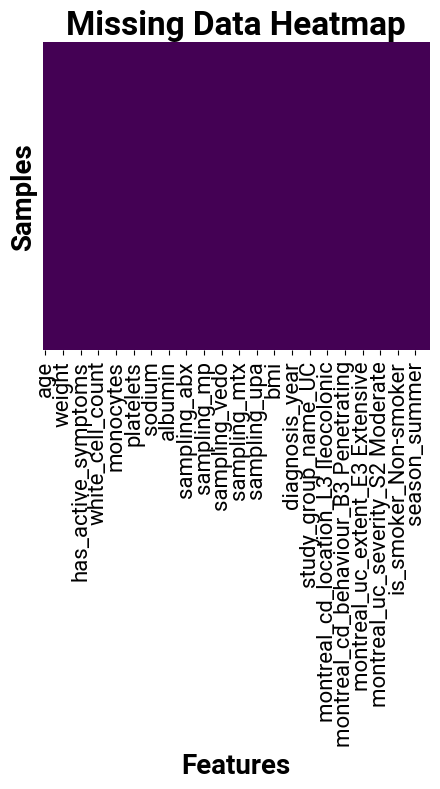

In [23]:
plot_missing_data_heatmap(df)

## Create X_australia and y_australia DataFrames

Perform checking to ensure they match input dataframe

In [24]:
# Create Y_australia
y_australia = df["fatigue_outcome"].copy()
X_australia = df.drop(columns=["fatigue_outcome"]).copy()
X_australia = X_australia[target_df.columns]

# Verify columns match
assert set(X_australia.columns) == set(target_df.columns), "Columns do not match!"

In [25]:
# Check if column order matches
columns_match = all(X_australia.columns[i] == target_df.columns[i] for i in range(len(X_australia.columns)))
print(f"Column order matches: {columns_match}")

Column order matches: True


In [26]:
# Ensure datatypes match
for col in X_australia.columns:
    X_australia[col] = X_australia[col].astype(target_df[col].dtype)

# Verify all data types match
print("\nChecking data types match:")
mismatched_types = [(col, X_australia[col].dtype, target_df[col].dtype) 
                    for col in X_australia.columns 
                    if X_australia[col].dtype != target_df[col].dtype]
if mismatched_types:
    print("Mismatched types:", mismatched_types)
else:
    print("All data types match!")


Checking data types match:
All data types match!


## Scale Data

In [27]:
# Load the scaler that was used on the training data
scaler = joblib.load(DNN_DIR / "exports" / "scaler_2025-04-24.pkl")

numerical_features = [
    col
    for col in NUMERICAL_FEATURES
    if col not in ["haematocrit", "ada_drug_level", "ifx_drug_level"]
]

# Apply the same scaling
X_australia[numerical_features] = scaler.transform(X_australia[numerical_features])

## Load the Keras Model

In [28]:
model = keras.saving.load_model(DNN_DIR / "exports" / "IFM-1_2025-04-24.keras")

In [29]:
# Get probability predictions
y_pred_proba = model.predict(X_australia)
# Get binary predictions using 0.5 threshold
y_pred = (y_pred_proba >= 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_australia, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        55
           1       0.59      0.66      0.62        35

    accuracy                           0.69        90
   macro avg       0.68      0.68      0.68        90
weighted avg       0.70      0.69      0.69        90



In [30]:
try:
    with open(BENCHMARKING_DIR / "statsmodels_logreg.pkl", 'rb') as f:
        logreg_model = pickle.load(f)

    # Prepare data for statsmodels prediction (add constant if needed)
    X_australia_const = sm.add_constant(X_australia)

    # Ensure columns match the model's exog_names, adding missing ones with 0 if necessary
    missing_cols = set(logreg_model.params.index) - set(X_australia_const.columns)
    for c in missing_cols:
        X_australia_const[c] = 0
    # Ensure the order of columns matches the model's parameters
    X_australia_const = X_australia_const[logreg_model.params.index]

    # Get probability predictions for Logistic Regression model
    y_pred_proba_logreg = logreg_model.predict(X_australia_const)

    # Calculate ROC curve and AUC for Logistic Regression model
    fpr_logreg, tpr_logreg, _ = roc_curve(y_australia, y_pred_proba_logreg)
    roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
    
    logreg_loaded = True
except FileNotFoundError:
    print("\\nWarning: Logistic regression model file not found at output/statsmodels/stasmodels_logreg.pkl")
    logreg_loaded = False
except Exception as e:
    print(f"\\nError loading or predicting with logistic regression model: {e}")
    logreg_loaded = False

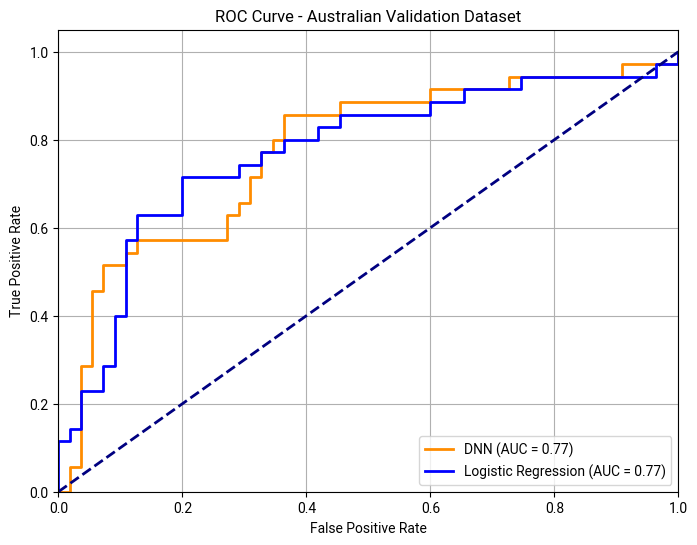

AUC Score (Keras DNN): 0.774
AUC Score (Logistic Regression): 0.772


In [31]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_australia, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'DNN (AUC = {roc_auc:.2f})')

# Plot Logistic Regression ROC if loaded successfully
if logreg_loaded:
    plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2,
             label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Australian Validation Dataset')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC score for Keras model
print(f"AUC Score (Keras DNN): {roc_auc:.3f}")
# Print AUC score for Logistic Regression model if loaded
if logreg_loaded:
    print(f"AUC Score (Logistic Regression): {roc_auc_logreg:.3f}")

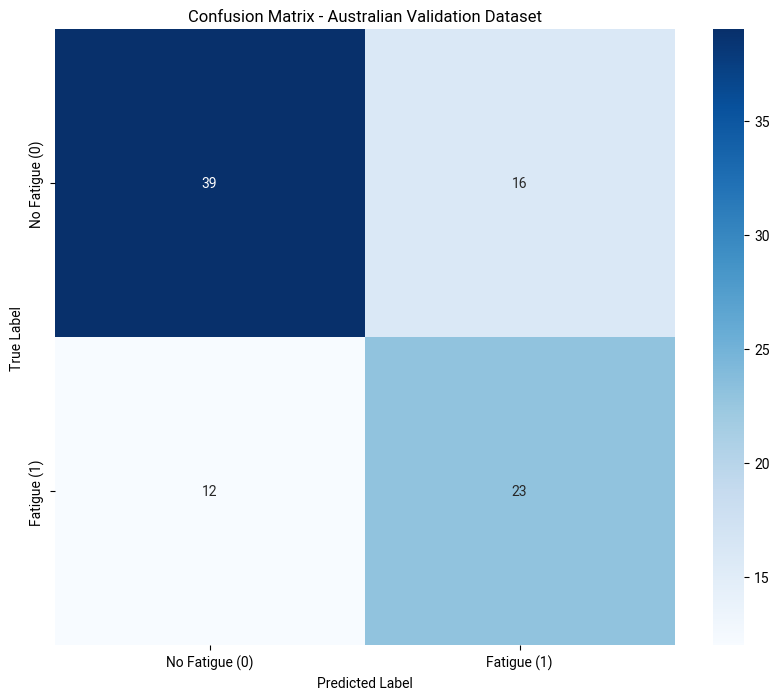


Detailed Confusion Matrix Interpretation:
True Negatives (Correctly predicted no fatigue): 39
False Positives (Incorrectly predicted fatigue): 16
False Negatives (Incorrectly predicted no fatigue): 12
True Positives (Correctly predicted fatigue): 23

Key Metrics:
Specificity (True Negative Rate): 0.709
Sensitivity (True Positive Rate): 0.657
Positive Predictive Value: 0.590
Negative Predictive Value: 0.765


In [32]:
# Create and plot confusion matrix with labels
cm = confusion_matrix(y_australia, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fatigue (0)', 'Fatigue (1)'],
            yticklabels=['No Fatigue (0)', 'Fatigue (1)'])
plt.title('Confusion Matrix - Australian Validation Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and display detailed metrics
tn, fp, fn, tp = cm.ravel()
print("\nDetailed Confusion Matrix Interpretation:")
print(f"True Negatives (Correctly predicted no fatigue): {tn}")
print(f"False Positives (Incorrectly predicted fatigue): {fp}")
print(f"False Negatives (Incorrectly predicted no fatigue): {fn}")
print(f"True Positives (Correctly predicted fatigue): {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nKey Metrics:")
print(f"Specificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")
print(f"Positive Predictive Value: {ppv:.3f}")
print(f"Negative Predictive Value: {npv:.3f}")

## Interrogate Confusion Matrix

In [33]:
# Create masks for each category based on actual and predicted values
# Need to flatten y_pred since it might have an extra dimension
y_pred_flat = y_pred.flatten()
true_positive_mask = (y_australia == 1) & (y_pred_flat == 1)
true_negative_mask = (y_australia == 0) & (y_pred_flat == 0)
false_positive_mask = (y_australia == 0) & (y_pred_flat == 1)
false_negative_mask = (y_australia == 1) & (y_pred_flat == 0)

# Create separate dataframes
tp_df = X_australia[true_positive_mask].copy()
tn_df = X_australia[true_negative_mask].copy()
fp_df = X_australia[false_positive_mask].copy()
fn_df = X_australia[false_negative_mask].copy()

# Verify the numbers match the confusion matrix
print("Dataset sizes:")
print(f"True Positives: {len(tp_df)}")
print(f"True Negatives: {len(tn_df)}")
print(f"False Positives: {len(fp_df)}")
print(f"False Negatives: {len(fn_df)}")

Dataset sizes:
True Positives: 23
True Negatives: 39
False Positives: 16
False Negatives: 12


In [34]:
with open(DNN_DIR / "exports" / "shap_explainer_2025-04-24.pkl", "rb") as f:
    explainer = pickle.load(f)

In [35]:
shap_values = explainer.shap_values(fn_df)
shap_values_class_1 = shap_values[:, :, 0]
fn_df[numerical_features] = scaler.inverse_transform(
    fn_df[numerical_features]
)

100%|██████████| 12/12 [00:09<00:00,  1.28it/s]


### False Negative Force Plots

In [36]:
# for i in range(len(fn_df)):
#     shap.force_plot(
#         explainer.expected_value[0],
#         shap_values_class_1[i],
#         fn_df.iloc[i],
#         matplotlib=True,
#         contribution_threshold=0.05,
#         text_rotation=30,
#         show=False,
#         plot_cmap="PRGn",
#     )
#     plt.show()

## Compare ML model vs Log Reg Model

### Compare Individual Classification

In [37]:
if not logreg_loaded:
    print("Logistic regression model was not loaded. Cannot compare misclassifications.")
else:
    # --- Get Binary Predictions ---
    # Keras DNN predictions (already calculated as y_pred)
    y_pred_dnn = y_pred.flatten() # Ensure it's a 1D array

    # Logistic Regression predictions
    y_pred_logreg = (y_pred_proba_logreg >= 0.5).astype(int)

    # --- Identify Classifications for Each Model ---
    # Using the index of the X_australia DataFrame to identify participants
    participant_indices = X_australia.index

    # Keras DNN
    tp_dnn_indices = participant_indices[(y_australia == 1) & (y_pred_dnn == 1)]
    tn_dnn_indices = participant_indices[(y_australia == 0) & (y_pred_dnn == 0)]
    fp_dnn_indices = participant_indices[(y_australia == 0) & (y_pred_dnn == 1)]
    fn_dnn_indices = participant_indices[(y_australia == 1) & (y_pred_dnn == 0)]

    # Logistic Regression
    tp_logreg_indices = participant_indices[(y_australia == 1) & (y_pred_logreg == 1)]
    tn_logreg_indices = participant_indices[(y_australia == 0) & (y_pred_logreg == 0)]
    fp_logreg_indices = participant_indices[(y_australia == 0) & (y_pred_logreg == 1)]
    fn_logreg_indices = participant_indices[(y_australia == 1) & (y_pred_logreg == 0)]

    # --- Compare True Positives ---
    tp_both = tp_dnn_indices.intersection(tp_logreg_indices)
    tp_dnn_only = tp_dnn_indices.difference(tp_logreg_indices)
    tp_logreg_only = tp_logreg_indices.difference(tp_dnn_indices)

    print("\n--- True Positive Comparison ---")
    print(f"Total TP (DNN): {len(tp_dnn_indices)}")
    print(f"Total TP (LogReg): {len(tp_logreg_indices)}")
    print(f"TP identified by BOTH models: {len(tp_both)}")
    print(f"TP identified by DNN ONLY: {len(tp_dnn_only)}")
    print(f"TP identified by LogReg ONLY: {len(tp_logreg_only)}")

    # --- Compare True Negatives ---
    tn_both = tn_dnn_indices.intersection(tn_logreg_indices)
    tn_dnn_only = tn_dnn_indices.difference(tn_logreg_indices)
    tn_logreg_only = tn_logreg_indices.difference(tn_dnn_indices)

    print("\n--- True Negative Comparison ---")
    print(f"Total TN (DNN): {len(tn_dnn_indices)}")
    print(f"Total TN (LogReg): {len(tn_logreg_indices)}")
    print(f"TN identified by BOTH models: {len(tn_both)}")
    print(f"TN identified by DNN ONLY: {len(tn_dnn_only)}")
    print(f"TN identified by LogReg ONLY: {len(tn_logreg_only)}")

    # --- Compare False Positives ---
    fp_both = fp_dnn_indices.intersection(fp_logreg_indices)
    fp_dnn_only = fp_dnn_indices.difference(fp_logreg_indices)
    fp_logreg_only = fp_logreg_indices.difference(fp_dnn_indices)

    print("\n--- False Positive Comparison ---")
    print(f"Total FP (DNN): {len(fp_dnn_indices)}")
    print(f"Total FP (LogReg): {len(fp_logreg_indices)}")
    print(f"FP identified by BOTH models: {len(fp_both)}")
    print(f"FP identified by DNN ONLY: {len(fp_dnn_only)}")
    print(f"FP identified by LogReg ONLY: {len(fp_logreg_only)}")
    # Optional: print the actual indices if needed
    # print(f"FP Both Indices: {fp_both.tolist()}")
    # print(f"FP DNN Only Indices: {fp_dnn_only.tolist()}")
    # print(f"FP LogReg Only Indices: {fp_logreg_only.tolist()}")


    # --- Compare False Negatives ---
    fn_both = fn_dnn_indices.intersection(fn_logreg_indices)
    fn_dnn_only = fn_dnn_indices.difference(fn_logreg_indices)
    fn_logreg_only = fn_logreg_indices.difference(fn_dnn_indices)

    print("\n--- False Negative Comparison ---")
    print(f"Total FN (DNN): {len(fn_dnn_indices)}")
    print(f"Total FN (LogReg): {len(fn_logreg_indices)}")
    print(f"FN identified by BOTH models: {len(fn_both)}")
    print(f"FN identified by DNN ONLY: {len(fn_dnn_only)}")
    print(f"FN identified by LogReg ONLY: {len(fn_logreg_only)}")
    # Optional: print the actual indices if needed
    # print(f"FN Both Indices: {fn_both.tolist()}")
    # print(f"FN DNN Only Indices: {fn_dnn_only.tolist()}")
    # print(f"FN LogReg Only Indices: {fn_logreg_only.tolist()}")


--- True Positive Comparison ---
Total TP (DNN): 23
Total TP (LogReg): 35
TP identified by BOTH models: 23
TP identified by DNN ONLY: 0
TP identified by LogReg ONLY: 12

--- True Negative Comparison ---
Total TN (DNN): 39
Total TN (LogReg): 0
TN identified by BOTH models: 0
TN identified by DNN ONLY: 39
TN identified by LogReg ONLY: 0

--- False Positive Comparison ---
Total FP (DNN): 16
Total FP (LogReg): 55
FP identified by BOTH models: 16
FP identified by DNN ONLY: 0
FP identified by LogReg ONLY: 39

--- False Negative Comparison ---
Total FN (DNN): 12
Total FN (LogReg): 0
FN identified by BOTH models: 0
FN identified by DNN ONLY: 12
FN identified by LogReg ONLY: 0


### Compare Feature Importance of ML Model vs Log Reg Model

In [38]:
# --- Check if models and explainer are loaded ---
if 'explainer' not in locals():
    print("SHAP explainer not found. Please load it first (e.g., from 'output/dnn/export/shap_explainer_2025-04-24.pkl').")
elif not logreg_loaded:
    print("Logistic regression model was not loaded. Cannot compare feature importance.")
else:
    print("\\n--- Calculating Feature Importance ---")

    # --- DNN Feature Importance (Mean Absolute SHAP) ---
    # Calculate SHAP values for the entire Australian validation set
    # Assuming explainer.shap_values returns a list [shap_values_class_0, shap_values_class_1]
    # Or if it returns a single array, it's likely for the positive class already.
    # Adjust index [1] if your explainer structure is different.
    try:
        if 'shap_values_australia' not in locals() and 'shap_values_australia' not in globals():
            print("Calculating SHAP values for DNN (this may take a while)...")
            shap_values_australia = explainer.shap_values(X_australia)
            print("SHAP values calculated.")
        else:
            print("Using previously calculated SHAP values for DNN.")

        shap_values_positive_class = shap_values_australia[:, :, 0]

        # Calculate mean absolute SHAP values
        mean_abs_shap = np.mean(np.abs(shap_values_positive_class), axis=0)
        dnn_importance = pd.Series(mean_abs_shap, index=X_australia.columns, name='DNN_MeanAbsSHAP')
        dnn_importance_sorted = dnn_importance.sort_values(ascending=False)
        print("\\nTop 10 DNN Features (Mean Absolute SHAP):")
        print(dnn_importance_sorted.head(10))
        dnn_calculated = True

    except Exception as e:
        print(f"Error calculating SHAP values for DNN: {e}")
        dnn_calculated = False


    # --- Logistic Regression Feature Importance (Coefficient Magnitude & p-value) ---
    logreg_params = logreg_model.params.drop('const', errors='ignore') # Drop intercept
    logreg_pvalues = logreg_model.pvalues.drop('const', errors='ignore')
    logreg_abs_coeffs = logreg_params.abs()

    logreg_importance = pd.DataFrame({
        'LogReg_AbsCoeff': logreg_abs_coeffs,
        'LogReg_PValue': logreg_pvalues
    })
    # Sort by absolute coefficient magnitude first, then p-value
    logreg_importance_sorted = logreg_importance.sort_values(by=['LogReg_AbsCoeff', 'LogReg_PValue'], ascending=[False, True])
    print("\\nTop 10 LogReg Features (Absolute Coefficient & P-value):")
    print(logreg_importance_sorted.head(10))
    logreg_calculated = True


    # --- Combined Comparison Table ---
    if dnn_calculated and logreg_calculated:
        comparison_df = pd.concat([dnn_importance, logreg_importance], axis=1).fillna(0) # Fill NaNs if featuresets differ slightly

        # Add ranks
        comparison_df['DNN_Rank'] = comparison_df['DNN_MeanAbsSHAP'].rank(ascending=False, method='first')
        comparison_df['LogReg_Rank'] = comparison_df['LogReg_AbsCoeff'].rank(ascending=False, method='first')

        # Sort by average rank or one model's rank
        comparison_df_sorted = comparison_df.sort_values(by='DNN_Rank')

        print("\\n--- Feature Importance Comparison (DNN vs LogReg) ---")
        # Display relevant columns
        print(comparison_df_sorted[['DNN_MeanAbsSHAP', 'DNN_Rank', 'LogReg_AbsCoeff', 'LogReg_PValue', 'LogReg_Rank']].head(20)) # Show top 20 by DNN rank


\n--- Calculating Feature Importance ---
Calculating SHAP values for DNN (this may take a while)...


100%|██████████| 90/90 [01:11<00:00,  1.26it/s]

SHAP values calculated.
\nTop 10 DNN Features (Mean Absolute SHAP):
has_active_symptoms                    0.144728
season_autumn                          0.091464
study_group_name_UC                    0.081338
sampling_steroids                      0.079564
basophils                              0.060236
montreal_cd_location_L3 Ileocolonic    0.050473
study_group_name_CD                    0.048931
age                                    0.045016
diagnosis_year                         0.040486
haemoglobin                            0.038683
Name: DNN_MeanAbsSHAP, dtype: float64
\nTop 10 LogReg Features (Absolute Coefficient & P-value):
                       LogReg_AbsCoeff  LogReg_PValue
sampling_risa                19.570406       0.999562
season_autumn                18.212739       0.990834
season_spring                17.956544       0.990963
season_winter                17.865272       0.991009
season_summer                17.582855       0.991151
study_group_name_UC           4

### SHAP Summary Plot

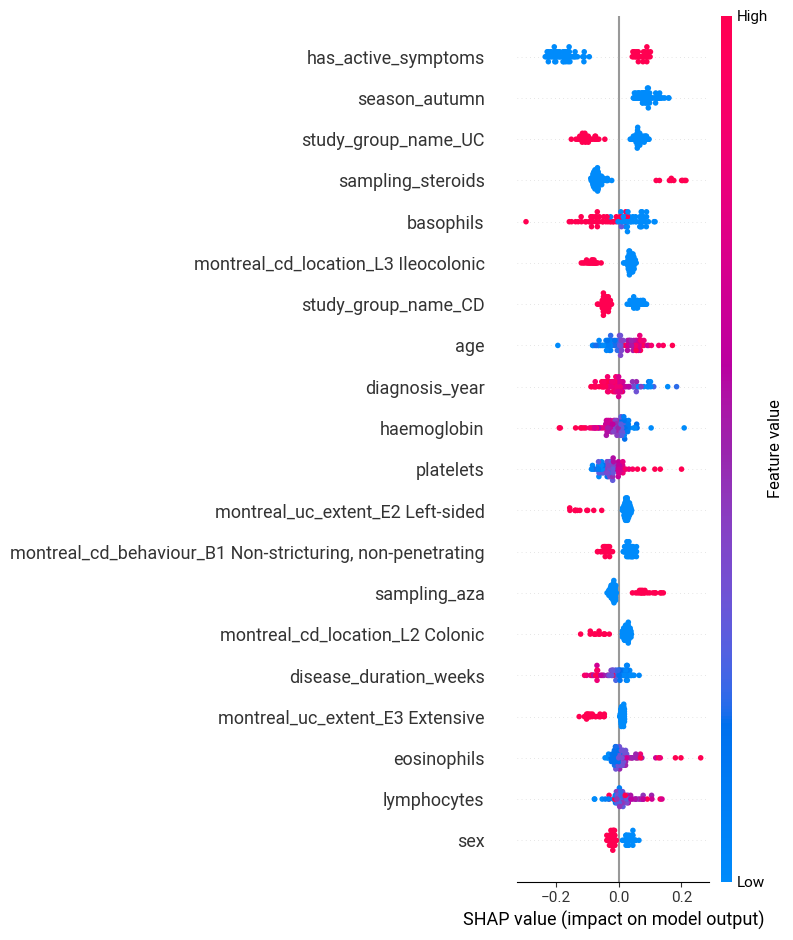

In [39]:
shap.summary_plot(
    shap_values_positive_class,
    X_australia,
    feature_names=X_australia.columns,
    show=False,
    max_display=20,
)
plt.tight_layout()
plt.show()

In [40]:
# Add this at the end of the notebook
output_dir = Path("output/validation/australia")
output_dir.mkdir(parents=True, exist_ok=True)

# Save X and y data
X_australia.to_csv(output_dir / "X_australia.csv", index=False)
pd.Series(y_australia).to_csv(output_dir / "y_australia.csv", index=False)
print(f"Saved preprocessed Australia validation data to {output_dir}")

Saved preprocessed Australia validation data to output/validation/australia
